######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

# ESML - accelerator: Batch scoring pipeline
- 1) `AutoMap datalake` & init ESML project
- 2) `Get earlier trained model`
- 3) `Score with GOLD_TEST` and calculate ML-performance




In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject
import pandas as pd
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
    

In [2]:
#p.describe()

In [9]:
try:
    print(p.GoldTest.to_pandas_dataframe().head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")

   Survived  Pclass                                               Name  \
0         1       3                           Miss. Bridget O'Driscoll   
1         0       2  Mrs. William John Robert (Dorothy Ann Wonnacot...   
2         1       2                               Master. Andre Mallet   
3         1       1                 Col. Oberst Alfons Simonius-Blumer   
4         1       1                        Miss. Jean Gertrude Hippach   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard  Fare  
0  female 27.00                        0                        0  7.75  
1  female 27.00                        1                        0 21.00  
2    male  1.00                        0                        2 37.00  
3    male 56.00                        0                        0 35.50  
4  female 16.00                        0                        1 57.98  


p.inference_mode = False
datastore = p.init(ws)

esml_dataset = p.DatasetByName("ds01_titanic") 
df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
p.save_silver(esml_dataset,df_bronze) 
df = esml_dataset.Silver.to_pandas_dataframe() 
gold_train = p.save_gold(df)
label = "Survived"
train_set, validate_set, test_set = p.split_gold_3(0.6,label) 

# TEST_SET scoring: CLASSIFICATION
 - Autoregisters in Azure ML Studio, the TEST-scoring as TAGS on the GOLD_TEST dataset
 - locally on build server, or via pipeline.

Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0
Replacing tag run_i

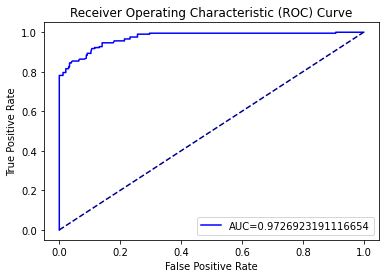

In [10]:
from baselayer_azure_ml import ESMLPipelineFactory

label = "Survived"
#rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label)
auc,accuracy,f1, precision,recall,matrix, plt = ESMLPipelineFactory(p).get_test_scoring_7_classification(label)

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Confusion Matrix:")
print(matrix)


# END - CLASSIFICATIN, TEST_SET scoring

# 2) CLASSIFICATION - predict_proba

In [14]:
# ESML specific start
source_best_run, fitted_model, experiment = p.get_best_model(p.ws)
X_test = p.GoldTest.to_pandas_dataframe() # X_test
# ESML end

from sklearn.metrics import mean_squared_error, r2_score,recall_score,average_precision_score,f1_score,roc_auc_score,accuracy_score,roc_curve,confusion_matrix

y_test = X_test.pop(label).to_frame() # y_test (true labels)
y_predict = fitted_model.predict(X_test) # y_predict (predicted labels)
y_predict_proba = fitted_model.predict_proba(X_test) # y_predict (predicted probabilities)

predict_proba = y_predict_proba[:, 1] # Positive values only
auc = roc_auc_score(y_test, predict_proba)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)

accuracy, precision, recall, f1, matrix = \
accuracy_score(y_test, y_predict),\
average_precision_score(y_test, y_predict),\
recall_score(y_test, y_predict),\
f1_score(y_test,y_predict), \
confusion_matrix(y_test, y_predict)


Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0

ROC AUC 0.97269231

In [15]:
print("ROC AUC", auc)

ROC AUC 0.9726923191116654


In [52]:
from scipy.sparse import issparse
def convert_to_list(df_series_or_ndarray):
    if issparse(df_series_or_ndarray):
        return df_series_or_ndarray.toarray().tolist()
    if (isinstance(df_series_or_ndarray, pd.DataFrame)):
        return df_series_or_ndarray.values.tolist()
    if (isinstance(df_series_or_ndarray, pd.Series)):
        return df_series_or_ndarray.values.tolist()
    if (isinstance(df_series_or_ndarray, np.ndarray)):
        return df_series_or_ndarray.tolist()
    return df_series_or_ndarray

In [57]:
probs =  y_predict_proba[:, 1].tolist() # positive. negative: [:, 0]
result = {'result': y_predict.tolist(), 'probability': probs}
pd.DataFrame.from_dict(result)

,result,probability
0,1,0.92
1,0,0.23
2,1,0.98
3,0,0.34
4,1,1.00
...,...,...
528,1,1.00
529,0,0.38
530,0,0.01
531,0,0.03
